In [45]:
!pip install xelatex
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex


In [2]:
X, y = load_digits(return_X_y=True)


In [28]:
load_digits= pd.read_csv('HIGGS_6M.csv')

In [31]:

np.ravel(load_digits)


array([1.        , 0.90754211, 0.32914728, ..., 0.80705976, 1.81057131,
       1.78045082])

In [32]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [33]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [34]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [35]:

np.ravel(data)

array([1.        , 0.90754211, 0.32914728, ..., 0.80705976, 1.81057131,
       1.78045082])

In [36]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [37]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [38]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000049
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000049
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000059
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000090
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000151
[t-SNE] Iteration 6: error = 4.0229674, gradient norm = 0.0000272
[t-SNE] Iteration 7: error = 4.0229668, gradient norm = 0.0000524
[t-SNE] Iteration 8: error = 4.0229642, gradient norm = 0.0001069
[t-SNE] Iteration 9: error = 4.0229522, gradient norm = 0.0002300
[t-SNE] Iteration 10: error = 4.0228910, gradient norm = 0.0005202
[t-SNE] Iteration 11: error = 4.0225493, gradient norm = 0.0012309
[t-SNE] Iteration 12: error = 4.0204793, gradient norm = 0.0030095
[t-SNE] Iteration 13: error = 4.0075027, gradient norm = 0.0071979
[t-SNE] Iteration 14: error = 3.9377645, gradient norm = 0.0139717
[t-SNE] Iteration 15: error = 3.7162107, gradient norm = 0.0179606
[t-S

[t-SNE] Iteration 124: error = 0.9908790, gradient norm = 0.0005062
[t-SNE] Iteration 125: error = 0.9891517, gradient norm = 0.0004943
[t-SNE] Iteration 126: error = 0.9874113, gradient norm = 0.0004803
[t-SNE] Iteration 127: error = 0.9857026, gradient norm = 0.0004785
[t-SNE] Iteration 128: error = 0.9840282, gradient norm = 0.0004696
[t-SNE] Iteration 129: error = 0.9823883, gradient norm = 0.0004397
[t-SNE] Iteration 130: error = 0.9807992, gradient norm = 0.0004482
[t-SNE] Iteration 131: error = 0.9792415, gradient norm = 0.0004581
[t-SNE] Iteration 132: error = 0.9776975, gradient norm = 0.0004289
[t-SNE] Iteration 133: error = 0.9761771, gradient norm = 0.0004083
[t-SNE] Iteration 134: error = 0.9746825, gradient norm = 0.0004166
[t-SNE] Iteration 135: error = 0.9732049, gradient norm = 0.0004214
[t-SNE] Iteration 136: error = 0.9717407, gradient norm = 0.0004100
[t-SNE] Iteration 137: error = 0.9702854, gradient norm = 0.0003972
[t-SNE] Iteration 138: error = 0.9688386, gradie

[t-SNE] Iteration 245: error = 0.8592711, gradient norm = 0.0003667
[t-SNE] Iteration 246: error = 0.8577777, gradient norm = 0.0003693
[t-SNE] Iteration 247: error = 0.8563403, gradient norm = 0.0003874
[t-SNE] Iteration 248: error = 0.8549872, gradient norm = 0.0003936
[t-SNE] Iteration 249: error = 0.8539208, gradient norm = 0.0004563
[t-SNE] Iteration 250: error = 0.8529304, gradient norm = 0.0004466
[t-SNE] Iteration 251: error = 0.8518576, gradient norm = 0.0003901
[t-SNE] Iteration 252: error = 0.8509711, gradient norm = 0.0004991
[t-SNE] Iteration 253: error = 0.8499326, gradient norm = 0.0004395
[t-SNE] Iteration 254: error = 0.8489518, gradient norm = 0.0004370
[t-SNE] Iteration 255: error = 0.8480264, gradient norm = 0.0004240
[t-SNE] Iteration 256: error = 0.8471390, gradient norm = 0.0004177
[t-SNE] Iteration 257: error = 0.8463120, gradient norm = 0.0003916
[t-SNE] Iteration 258: error = 0.8455885, gradient norm = 0.0003561
[t-SNE] Iteration 259: error = 0.8449044, gradie

[t-SNE] Iteration 366: error = 0.7824117, gradient norm = 0.0002239
[t-SNE] Iteration 367: error = 0.7820941, gradient norm = 0.0002475
[t-SNE] Iteration 368: error = 0.7817733, gradient norm = 0.0002098
[t-SNE] Iteration 369: error = 0.7814526, gradient norm = 0.0001674
[t-SNE] Iteration 370: error = 0.7811352, gradient norm = 0.0002084
[t-SNE] Iteration 371: error = 0.7808151, gradient norm = 0.0002169
[t-SNE] Iteration 372: error = 0.7804900, gradient norm = 0.0001917
[t-SNE] Iteration 373: error = 0.7801610, gradient norm = 0.0002024
[t-SNE] Iteration 374: error = 0.7798226, gradient norm = 0.0001930
[t-SNE] Iteration 375: error = 0.7794738, gradient norm = 0.0001994
[t-SNE] Iteration 376: error = 0.7791202, gradient norm = 0.0002022
[t-SNE] Iteration 377: error = 0.7787791, gradient norm = 0.0001744
[t-SNE] Iteration 378: error = 0.7784564, gradient norm = 0.0002054
[t-SNE] Iteration 379: error = 0.7781297, gradient norm = 0.0001926
[t-SNE] Iteration 380: error = 0.7778002, gradie

[t-SNE] Iteration 487: error = 0.7574267, gradient norm = 0.0001050
[t-SNE] Iteration 488: error = 0.7573043, gradient norm = 0.0001019
[t-SNE] Iteration 489: error = 0.7571827, gradient norm = 0.0001028
[t-SNE] Iteration 490: error = 0.7570615, gradient norm = 0.0000928
[t-SNE] Iteration 491: error = 0.7569414, gradient norm = 0.0001014
[t-SNE] Iteration 492: error = 0.7568218, gradient norm = 0.0001033
[t-SNE] Iteration 493: error = 0.7567023, gradient norm = 0.0000946
[t-SNE] Iteration 494: error = 0.7565834, gradient norm = 0.0000972
[t-SNE] Iteration 495: error = 0.7564645, gradient norm = 0.0000911
[t-SNE] Iteration 496: error = 0.7563466, gradient norm = 0.0000971
[t-SNE] Iteration 497: error = 0.7562287, gradient norm = 0.0000939
[t-SNE] Iteration 498: error = 0.7561114, gradient norm = 0.0001034
[t-SNE] Iteration 499: error = 0.7559945, gradient norm = 0.0001237
[t-SNE] Iteration 500: error = 0.7558783, gradient norm = 0.0001429
[t-SNE] Iteration 501: error = 0.7557618, gradie

[t-SNE] Iteration 608: error = 0.7455613, gradient norm = 0.0000698
[t-SNE] Iteration 609: error = 0.7454854, gradient norm = 0.0000721
[t-SNE] Iteration 610: error = 0.7454099, gradient norm = 0.0000781
[t-SNE] Iteration 611: error = 0.7453346, gradient norm = 0.0000900
[t-SNE] Iteration 612: error = 0.7452594, gradient norm = 0.0000927
[t-SNE] Iteration 613: error = 0.7451841, gradient norm = 0.0000801
[t-SNE] Iteration 614: error = 0.7451091, gradient norm = 0.0000674
[t-SNE] Iteration 615: error = 0.7450349, gradient norm = 0.0000809
[t-SNE] Iteration 616: error = 0.7449608, gradient norm = 0.0000799
[t-SNE] Iteration 617: error = 0.7448868, gradient norm = 0.0000659
[t-SNE] Iteration 618: error = 0.7448138, gradient norm = 0.0000775
[t-SNE] Iteration 619: error = 0.7447407, gradient norm = 0.0000738
[t-SNE] Iteration 620: error = 0.7446679, gradient norm = 0.0000682
[t-SNE] Iteration 621: error = 0.7445956, gradient norm = 0.0000748
[t-SNE] Iteration 622: error = 0.7445233, gradie

[t-SNE] Iteration 729: error = 0.7377385, gradient norm = 0.0000593
[t-SNE] Iteration 730: error = 0.7376825, gradient norm = 0.0000560
[t-SNE] Iteration 731: error = 0.7376265, gradient norm = 0.0000559
[t-SNE] Iteration 732: error = 0.7375704, gradient norm = 0.0000581
[t-SNE] Iteration 733: error = 0.7375143, gradient norm = 0.0000558
[t-SNE] Iteration 734: error = 0.7374582, gradient norm = 0.0000541
[t-SNE] Iteration 735: error = 0.7374021, gradient norm = 0.0000563
[t-SNE] Iteration 736: error = 0.7373460, gradient norm = 0.0000559
[t-SNE] Iteration 737: error = 0.7372898, gradient norm = 0.0000577
[t-SNE] Iteration 738: error = 0.7372336, gradient norm = 0.0000612
[t-SNE] Iteration 739: error = 0.7371775, gradient norm = 0.0000664
[t-SNE] Iteration 740: error = 0.7371215, gradient norm = 0.0000793
[t-SNE] Iteration 741: error = 0.7370655, gradient norm = 0.0000820
[t-SNE] Iteration 742: error = 0.7370094, gradient norm = 0.0000702
[t-SNE] Iteration 743: error = 0.7369536, gradie

[t-SNE] Iteration 850: error = 0.7314953, gradient norm = 0.0000496
[t-SNE] Iteration 851: error = 0.7314470, gradient norm = 0.0000514
[t-SNE] Iteration 852: error = 0.7313987, gradient norm = 0.0000547
[t-SNE] Iteration 853: error = 0.7313503, gradient norm = 0.0000569
[t-SNE] Iteration 854: error = 0.7313019, gradient norm = 0.0000530
[t-SNE] Iteration 855: error = 0.7312535, gradient norm = 0.0000506
[t-SNE] Iteration 856: error = 0.7312053, gradient norm = 0.0000535
[t-SNE] Iteration 857: error = 0.7311570, gradient norm = 0.0000533
[t-SNE] Iteration 858: error = 0.7311087, gradient norm = 0.0000532
[t-SNE] Iteration 859: error = 0.7310604, gradient norm = 0.0000517
[t-SNE] Iteration 860: error = 0.7310122, gradient norm = 0.0000553
[t-SNE] Iteration 861: error = 0.7309640, gradient norm = 0.0000572
[t-SNE] Iteration 862: error = 0.7309156, gradient norm = 0.0000542
[t-SNE] Iteration 863: error = 0.7308673, gradient norm = 0.0000507
[t-SNE] Iteration 864: error = 0.7308191, gradie

[t-SNE] Iteration 971: error = 0.7255565, gradient norm = 0.0000619
[t-SNE] Iteration 972: error = 0.7255083, gradient norm = 0.0000580
[t-SNE] Iteration 973: error = 0.7254603, gradient norm = 0.0000527
[t-SNE] Iteration 974: error = 0.7254125, gradient norm = 0.0000584
[t-SNE] Iteration 975: error = 0.7253646, gradient norm = 0.0000551
[t-SNE] Iteration 976: error = 0.7253168, gradient norm = 0.0000538
[t-SNE] Iteration 977: error = 0.7252693, gradient norm = 0.0000613
[t-SNE] Iteration 978: error = 0.7252217, gradient norm = 0.0000584
[t-SNE] Iteration 979: error = 0.7251741, gradient norm = 0.0000571
[t-SNE] Iteration 980: error = 0.7251265, gradient norm = 0.0000518
[t-SNE] Iteration 981: error = 0.7250790, gradient norm = 0.0000538
[t-SNE] Iteration 982: error = 0.7250315, gradient norm = 0.0000549
[t-SNE] Iteration 983: error = 0.7249839, gradient norm = 0.0000513
[t-SNE] Iteration 984: error = 0.7249364, gradient norm = 0.0000551
[t-SNE] Iteration 985: error = 0.7248888, gradie

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

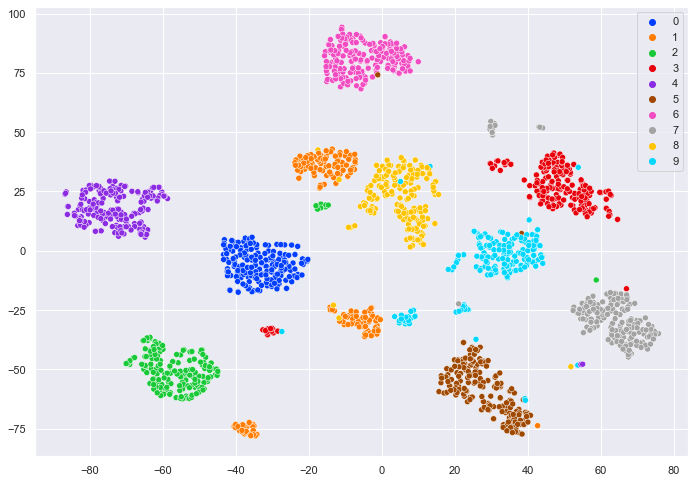

In [39]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

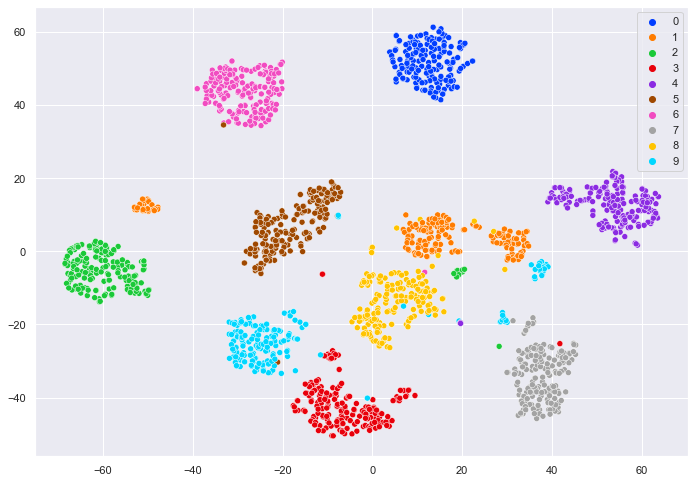

In [40]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

NameError: name 'supportvectorclassifier' is not defined

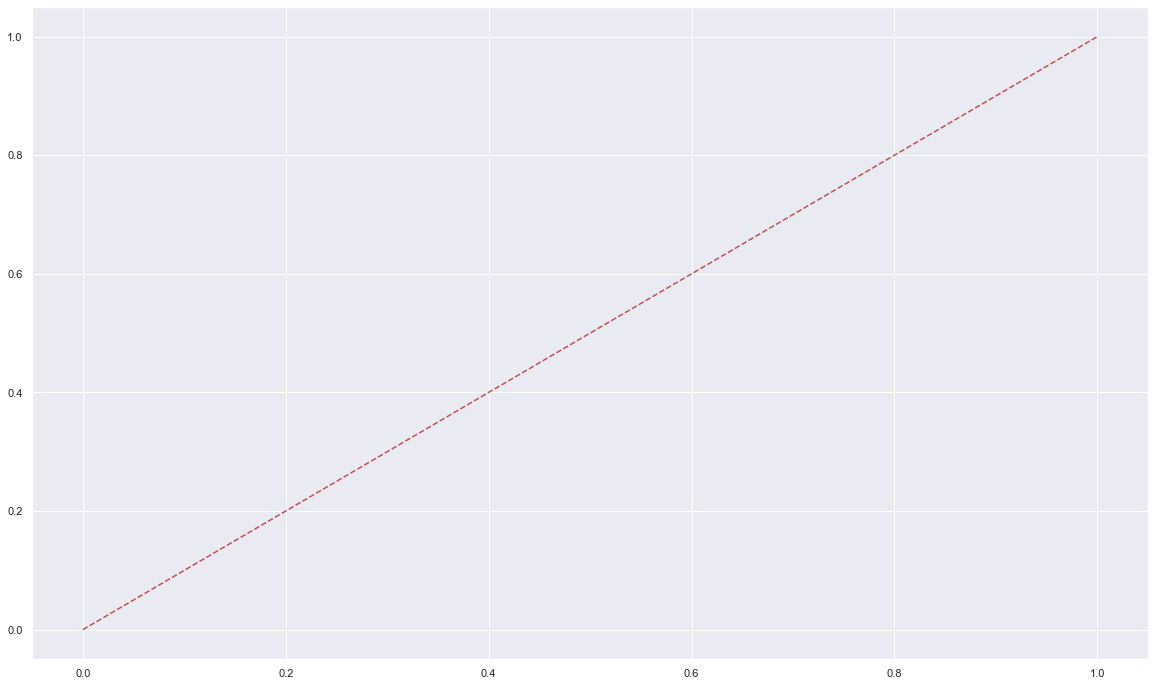

In [52]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')
probs = supportvectorclassifier.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
label = 'TSNE' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [60]:
# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(X_embedded, X)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

ValueError: continuous-multioutput format is not supported